In [4]:
%load_ext autoreload
%autoreload 2

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [349]:
from utils.make_data import generate_autoregressive_forecast_dataset
from models.conformal import ConformalForecaster

In [362]:
def plot_miscoverage_examples(test_dataset, coverages, intervals):
    miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
    fig, axs = plt.subplots(5, 2, figsize=(10, 10), sharey=True)

    for ax in axs.flat:
        i = np.random.choice(miscovered_idx)
        ax.fill_between(range(test_dataset[i][1].size(0)),
                         intervals[i, 0].flatten().tolist(), 
                         intervals[i, 1].flatten().tolist(), 
                         color="r", alpha=0.25)
        ax.plot(intervals[i, 0].flatten().tolist(), linestyle="--", color="r")
        ax.plot(intervals[i, 1].flatten().tolist(), linestyle="--", color="r")
        # plt.plot(Y_predicted[0][0], linestyle="--", linewidth=3, color="r")

        ax.scatter(range(test_dataset[i][1].size(0)), test_dataset[i][1].flatten().tolist(), color="black")

        ax.set(xlabel='Time step', ylabel='Prediction')
    plt.show()

## Generate datasets

In [350]:
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=20)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=100, horizon=20)

## Conformal forecaster

In [351]:
model = ConformalForecaster(embedding_size=8, horizon=20, error_rate=0.05)
model.fit(train_dataset, calibration_dataset, epochs=150, lr=0.01, batch_size=100)

Epoch: 0	Train loss: 117.06924743652344
Epoch: 50	Train loss: 21.536456489562987
Epoch: 100	Train loss: 21.50290927886963


In [352]:
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

% of series within predicted intervals: 0.9760000109672546


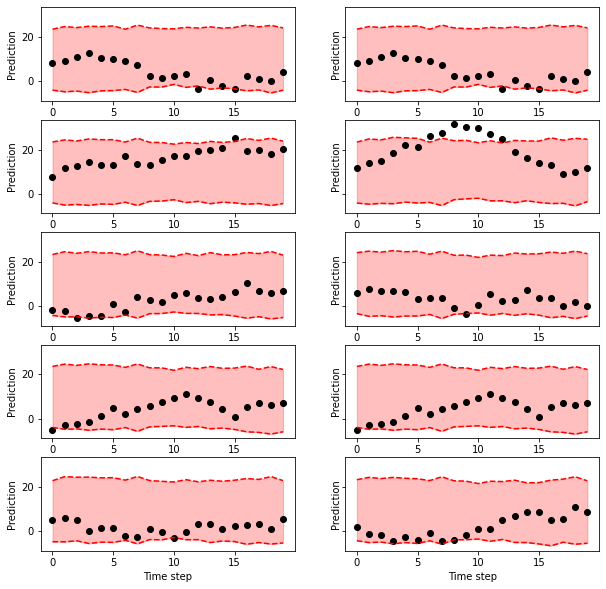

In [357]:
plot_miscoverage_examples(test_dataset, coverages, intervals)

## Shorter training intervals

Set `seq_len=10` and predict for horizon of 10 time steps.

In [355]:
train_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10)
calibration_dataset_short = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10)
test_dataset_short = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=20, horizon=10)

In [358]:
model_short = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [360]:
model_short.fit(train_dataset_short, calibration_dataset_short, epochs=100, lr=0.01, batch_size=100)
coverages_short, intervals_short = model_short.evaluate_coverage(test_dataset_short)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages_short.float(), dim=0).item()))

Epoch: 0	Train loss: 19.59149513244629
Epoch: 50	Train loss: 19.295860862731935
% of series within predicted intervals: 0.9620000123977661


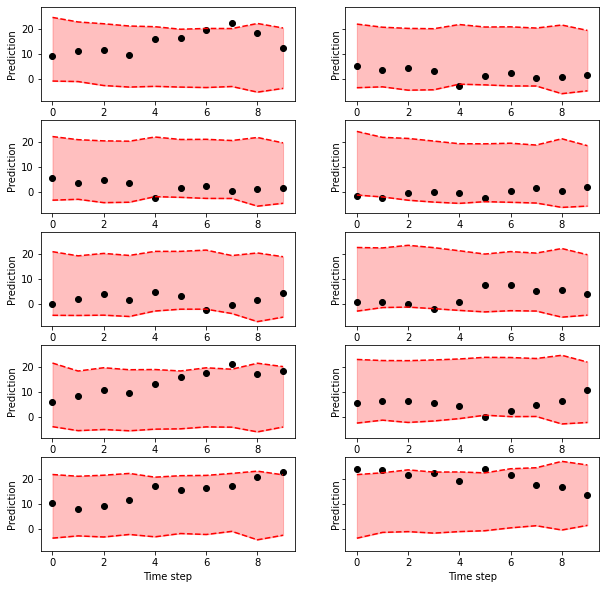

In [363]:
plot_miscoverage_examples(test_dataset_short, coverages_short, intervals_short)